In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import math
import cv2
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from glob import glob

In [3]:
masks_train = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/traincrop/*.png'))

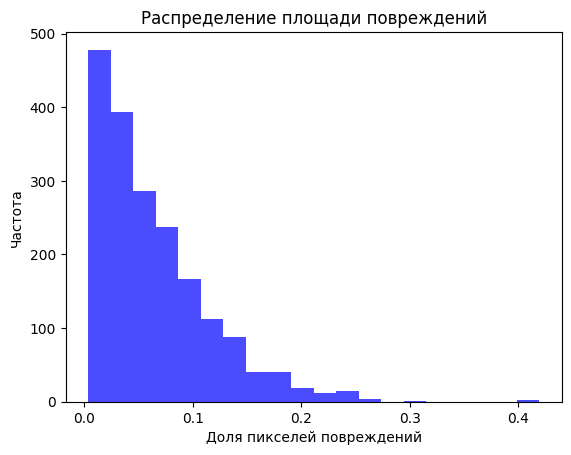

In [4]:
mask_sizes = []
for mask_path in masks_train:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_sizes.append(np.sum(mask > 0) / (mask.shape[0] * mask.shape[1]))

plt.hist(mask_sizes, bins=20, color='blue', alpha=0.7)
plt.xlabel("Доля пикселей повреждений")
plt.ylabel("Частота")
plt.title("Распределение площади повреждений")
plt.show()

# Рассмотрим распределение размеров масок на тренировочной выборке

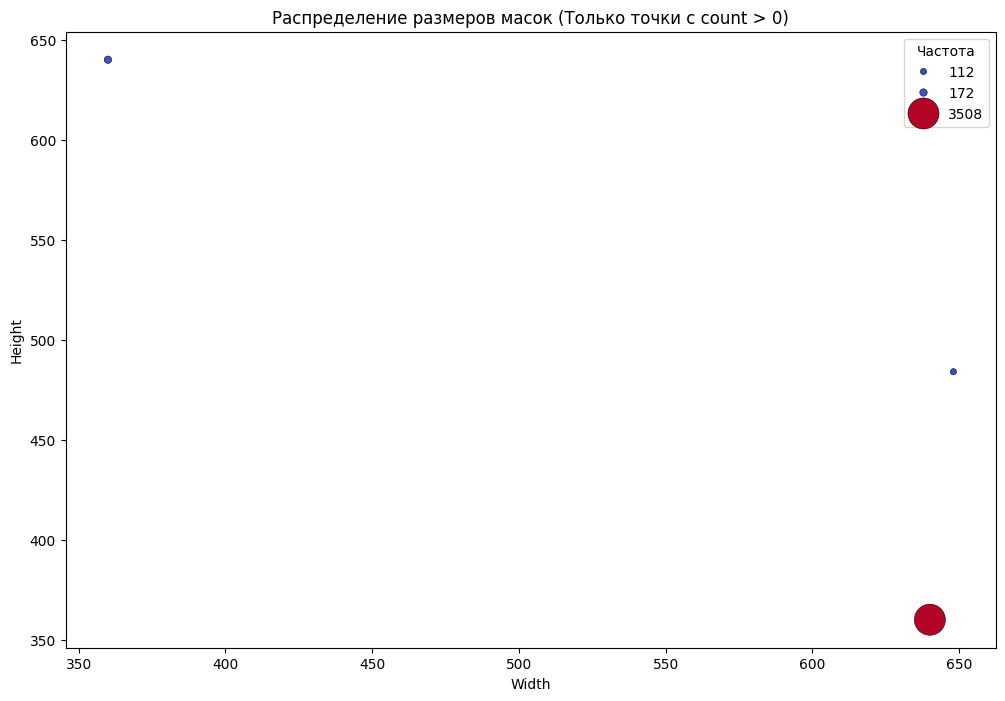

In [5]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

def image_size_distrib_visualizer(mask_dir):
    size_counts = Counter()
    for mask_name in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_name)
        try:
            with Image.open(mask_path) as img:
                width, height = img.size
                size_counts[(width, height)] += 1
        except Exception as e:
            print(f"Ошибка с файлом {mask_name}: {e}")
    
    widths, heights, freqs = zip(*[(w, h, count) for (w, h), count in size_counts.items()])
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=widths, y=heights, size=freqs, sizes=(20, 500), hue=freqs, palette="coolwarm", edgecolor="black")
    
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Распределение размеров масок (Только точки с count > 0)")
    plt.legend(title="Частота")
    plt.show()
    
mask_dir_train = "D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/traincrop/"
image_size_distrib_visualizer(mask_dir_train)

#  Теперь на валидационной выборке

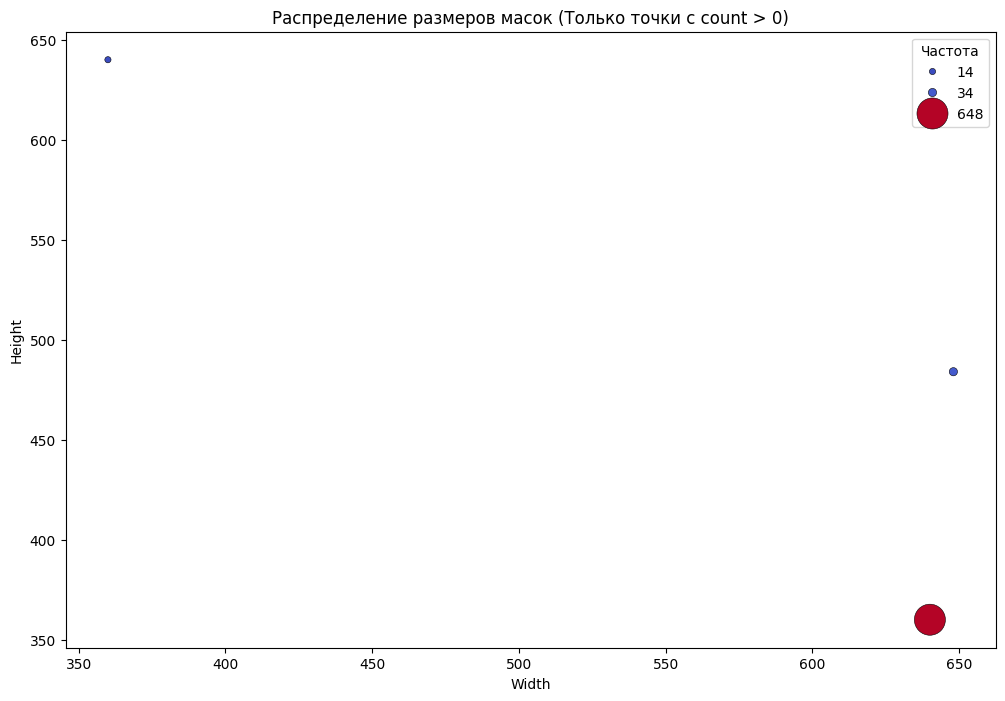

In [6]:
mask_dir_val = "D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/valcrop/"
image_size_distrib_visualizer(mask_dir_val)

# Теперь посмотрим, в каких областях чаще встречаются повреждения

In [7]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image


def defects_distrib_visualizer(masks_train,TARGET_SIZE,plot_size):
    heatmap = np.zeros(TARGET_SIZE, dtype=np.float32)
    count_masks = 0  # Счетчик использованных масок
    
    for mask_path in masks_train:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #print(mask.shape)
        if mask.shape == TARGET_SIZE:
            #print('a')
            heatmap += (mask > 0).astype(np.float32)  # 1, если пиксель положительный
            count_masks += 1
    
    plt.figure(figsize=plot_size)
    sns.heatmap(heatmap, cmap="coolwarm", cbar=True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Распределение положительного класса (маски {TARGET_SIZE[0]}x{TARGET_SIZE[1]})")
    plt.show()

## на тренировочной выборке

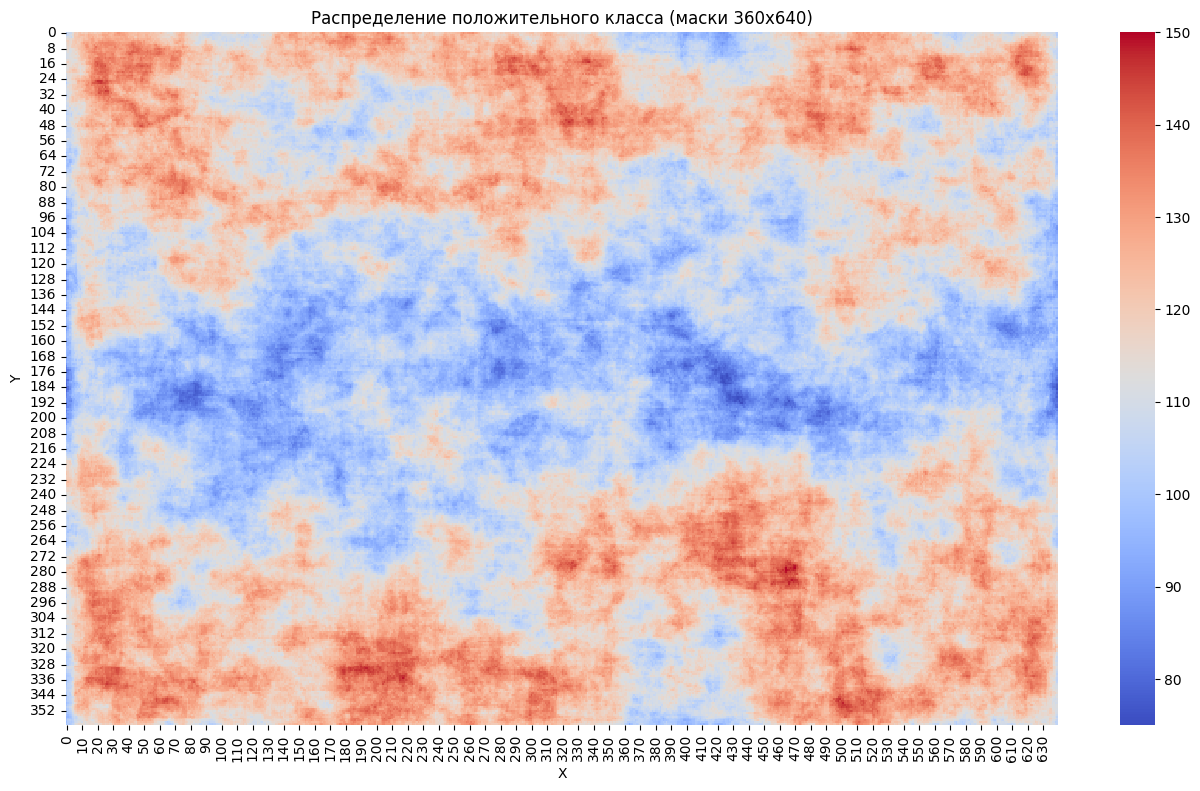

In [8]:
masks_train = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/traincrop/*.png'))
TARGET_SIZE = (360, 640)
plot_size = (16,9)
defects_distrib_visualizer(masks_train,TARGET_SIZE,plot_size)

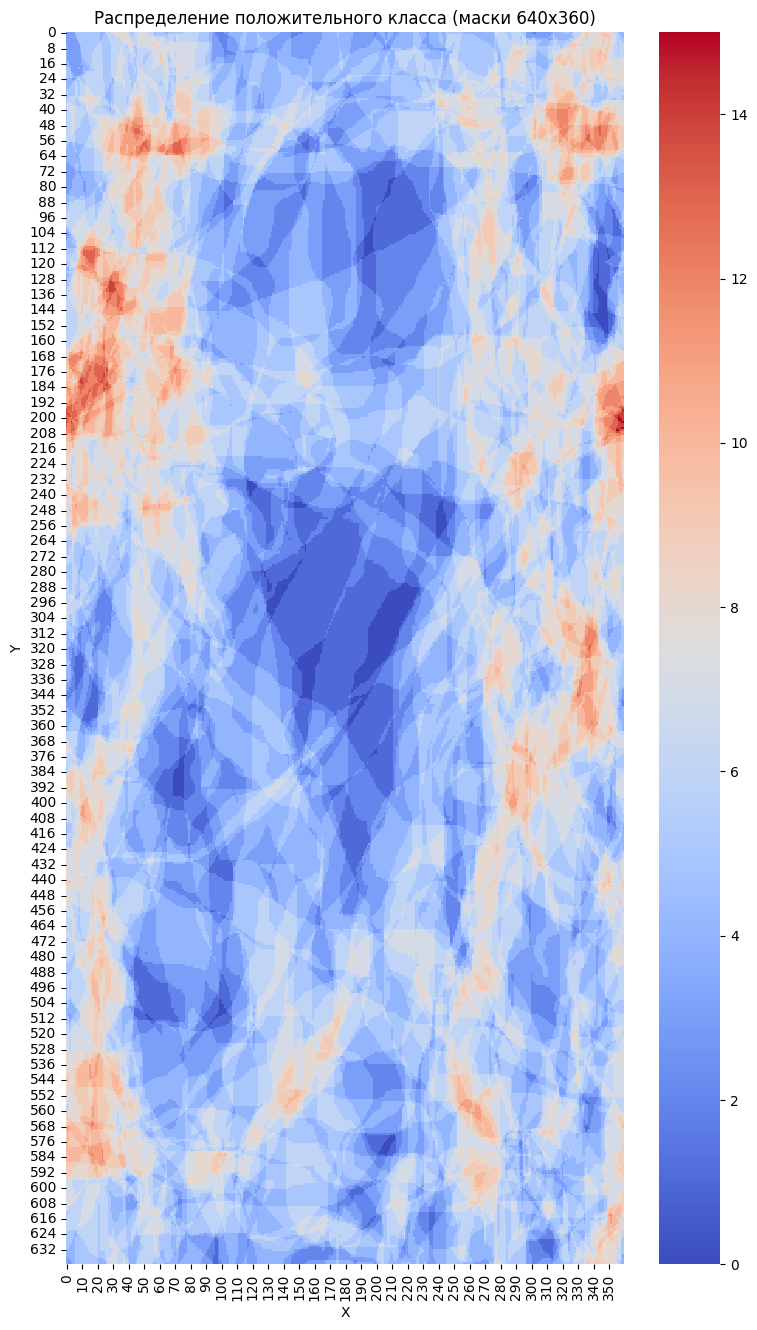

In [9]:
masks_train = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/traincrop/*.png'))
TARGET_SIZE = (640, 360)
plot_size = (9,16)
defects_distrib_visualizer(masks_train,TARGET_SIZE,plot_size)

## на валидационной выборке

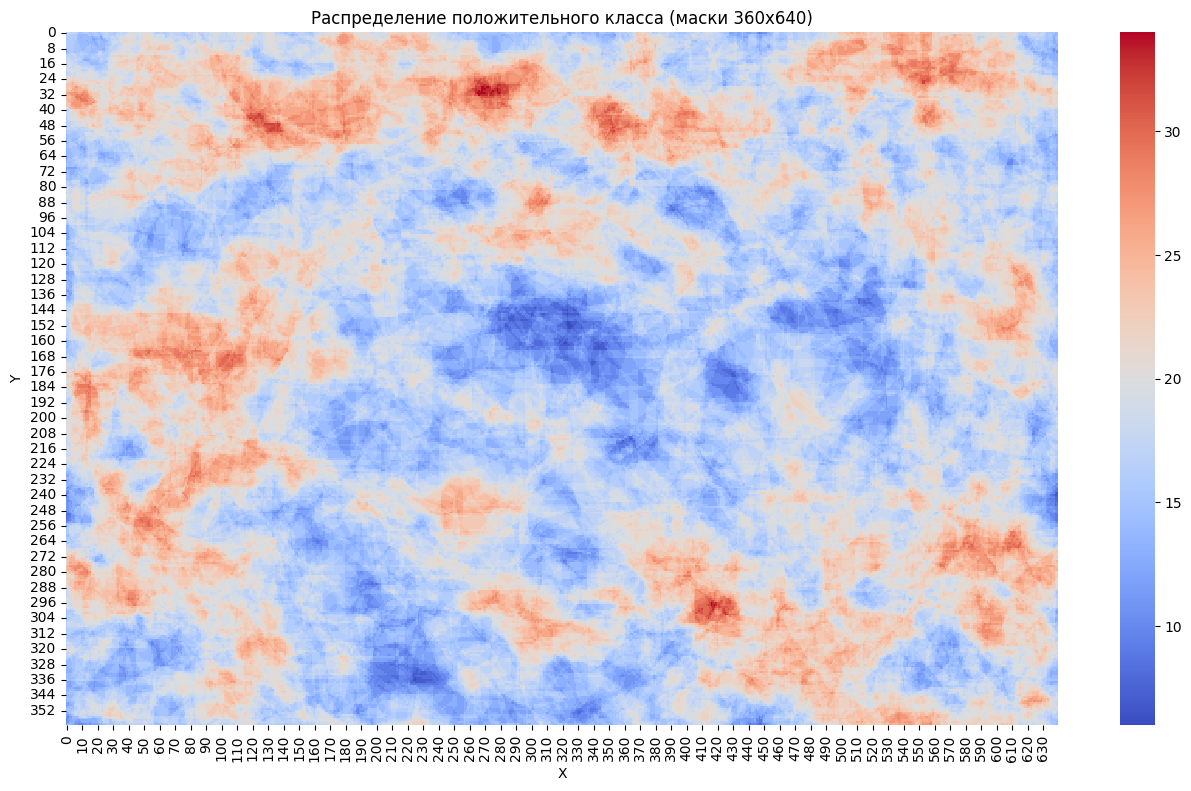

In [10]:
masks_val = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/valcrop/*.png'))
TARGET_SIZE = (360, 640)
plot_size = (16,9)
defects_distrib_visualizer(masks_val,TARGET_SIZE,plot_size)

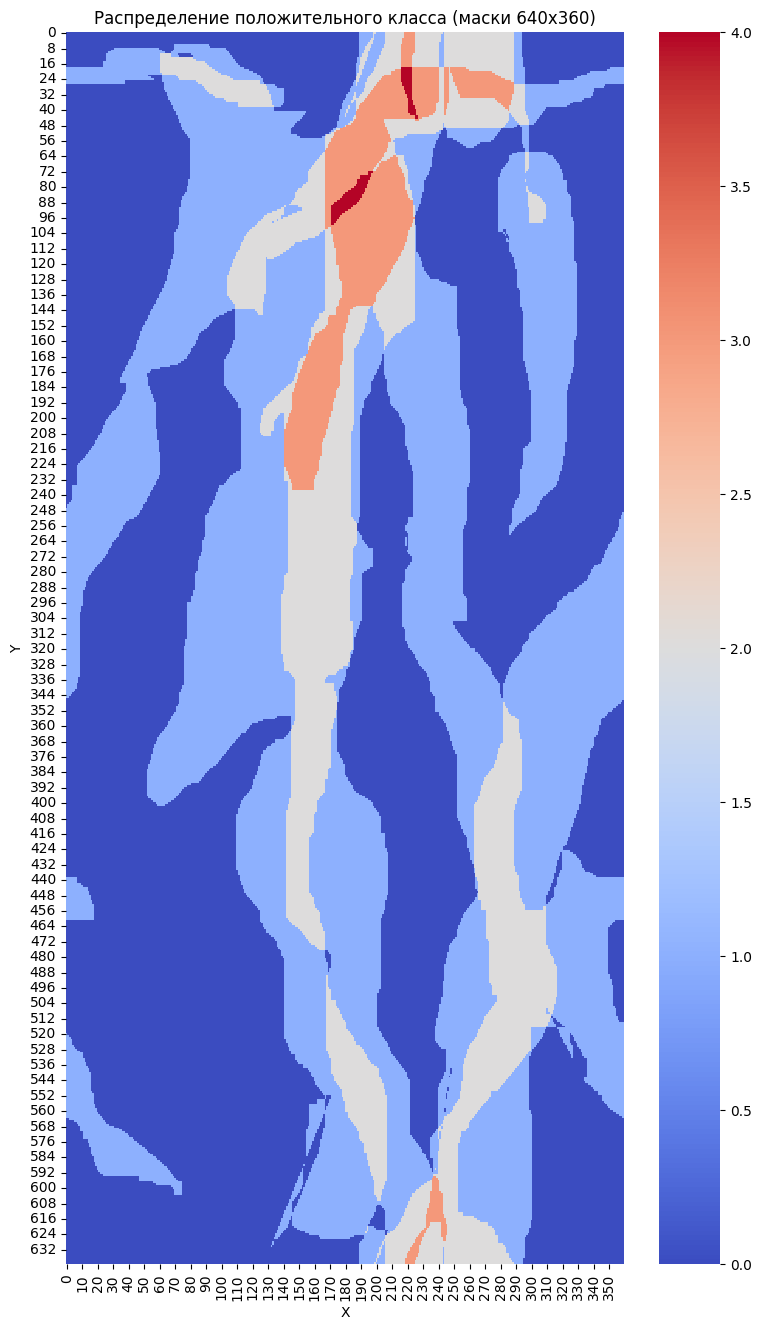

In [11]:
masks_val = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/valcrop/*.png'))
TARGET_SIZE = (640, 360)
plot_size = (9,16)
defects_distrib_visualizer(masks_val,TARGET_SIZE,plot_size)

# на тестовой выборке

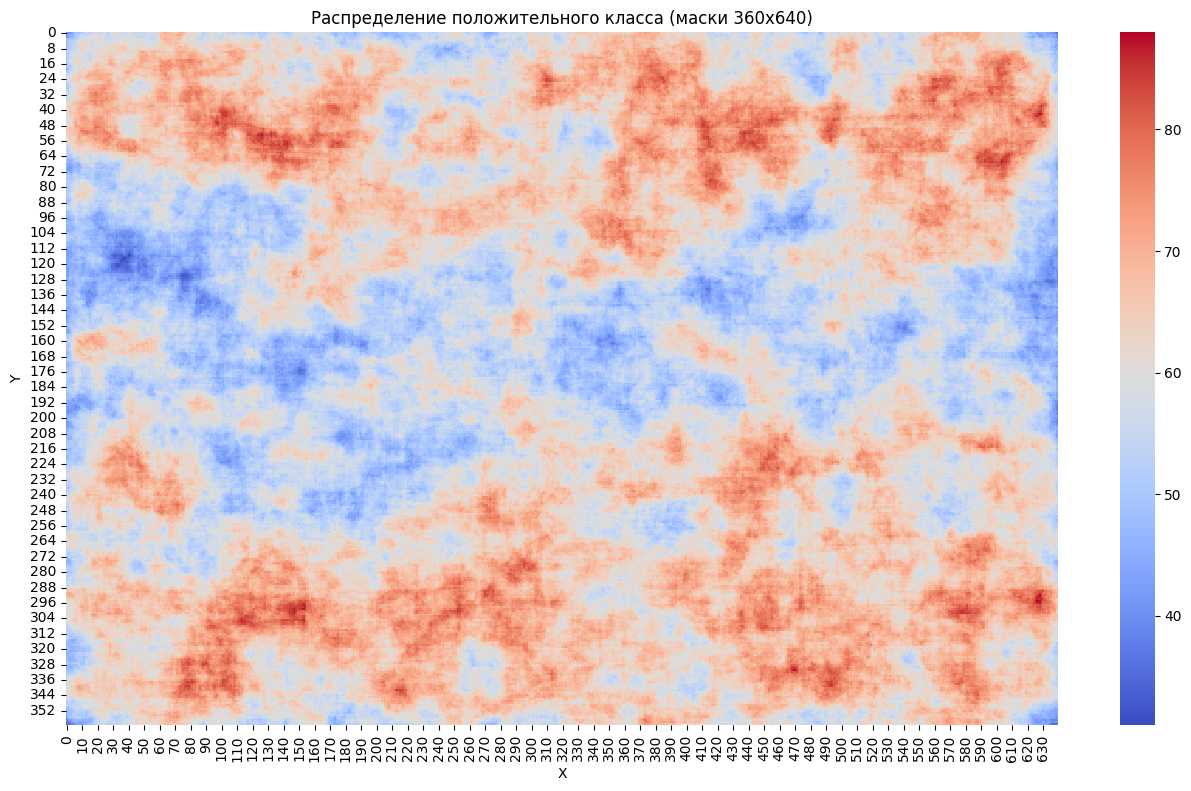

In [12]:
masks_test = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/testcrop/*.png'))
TARGET_SIZE = (360, 640)
plot_size = (16,9)
defects_distrib_visualizer(masks_test,TARGET_SIZE,plot_size)

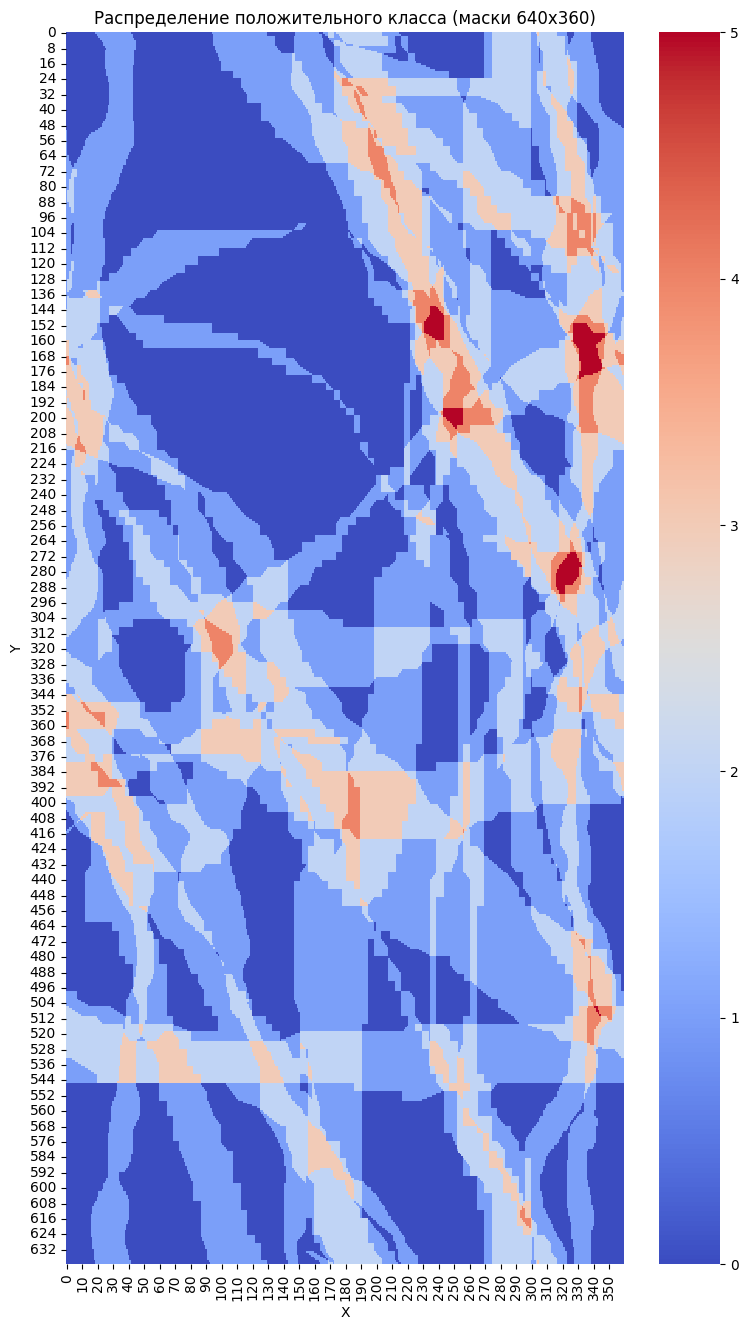

In [13]:
masks_test = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/testcrop/*.png'))
TARGET_SIZE = (640,360)
plot_size = (9,16)
defects_distrib_visualizer(masks_test,TARGET_SIZE,plot_size)

Видим, что чаще всего дефекты встречаются на краях кропов. поэтому при приведении изображений к одному размеру выгодно воспользоваться трюком, используемым в unet (overlap-tile strategy). В этом методе мы отталкиваемся от того, что после свертки новое изображение содержит меньше информации о пикселях, находящихся близкор к краям(по этим пикселям мы меньшее число раз проходимся ядром). Поэтому можем расширить исходное изображение путем отражения краев, но после свертки брать только участок нужных нам размеров.

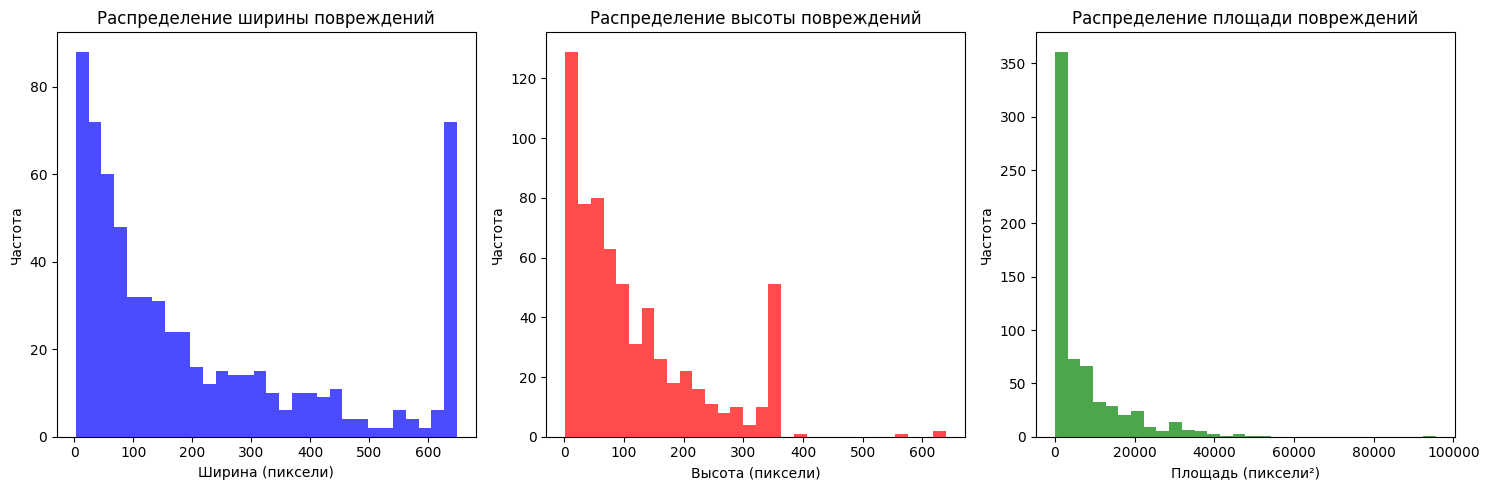

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

masks_val = sorted(glob('D:/pavement crack datasets-20210103T153625Z-001/pavement crack datasets/CRACK500/valcrop/*.png'))

widths = []
heights = []
areas = []
for mask_path in masks_val:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    mask = np.array(mask)
    
    _, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    # Поиск контуров повреждений
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Извлекаем размеры объектов
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Границы объекта
        area = cv2.contourArea(contour)  # Площадь объекта

        if area > 10: # фильтруем шумы
            widths.append(w)
            heights.append(h)
            areas.append(area)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(widths, bins=30, color='blue', alpha=0.7)
ax[0].set_title("Распределение ширины повреждений")
ax[0].set_xlabel("Ширина (пиксели)")
ax[0].set_ylabel("Частота")

ax[1].hist(heights, bins=30, color='red', alpha=0.7)
ax[1].set_title("Распределение высоты повреждений")
ax[1].set_xlabel("Высота (пиксели)")
ax[1].set_ylabel("Частота")

ax[2].hist(areas, bins=30, color='green', alpha=0.7)
ax[2].set_title("Распределение площади повреждений")
ax[2].set_xlabel("Площадь (пиксели²)")
ax[2].set_ylabel("Частота")

plt.tight_layout()
plt.show()


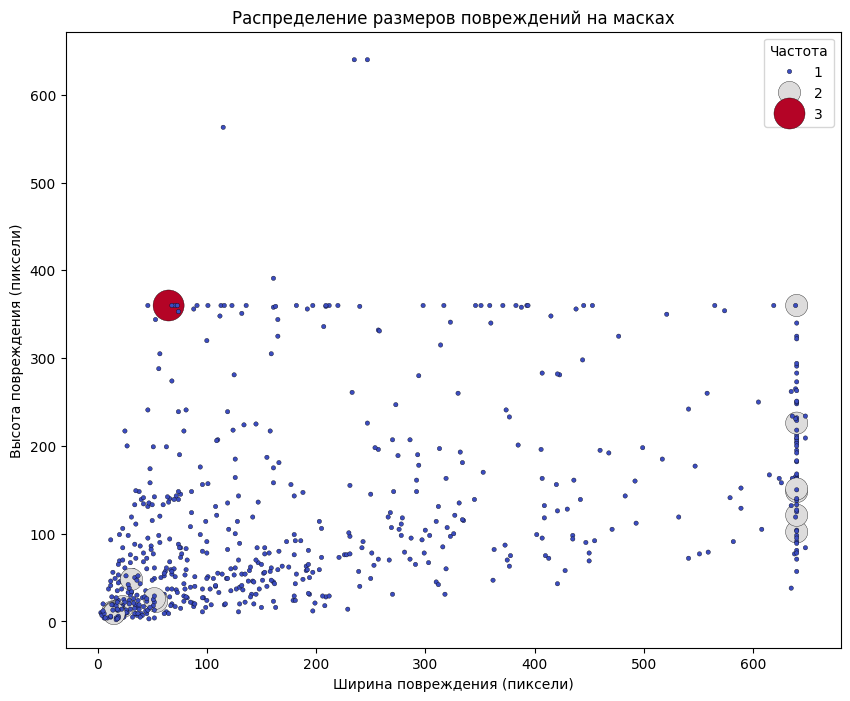

In [16]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

size_counts = Counter()

for mask_path in masks_val:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    mask = np.array(mask)

    _, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    # Поиск контуров повреждений
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Извлекаем размеры объектов
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Границы объекта
        area = cv2.contourArea(contour)  # Площадь объекта

        if area > 10: # фильтруем шумы
            size_counts[(w, h)] += 1


#Преобразуем в массивы для heatmap
widths, heights, freqs = zip(*[(w, h, count) for (w, h), count in size_counts.items()])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=widths, y=heights, size=freqs, sizes=(10, 500), hue=freqs, palette="coolwarm", edgecolor="black")

plt.xlabel("Ширина повреждения (пиксели)")
plt.ylabel("Высота повреждения (пиксели)")
plt.title("Распределение размеров повреждений на масках")
plt.legend(title="Частота")
plt.show()


Видим, что больше всего на масках мелких повреждений